In [1]:
import pandas as pd
import os

/Users/sunruoyao/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [5]:
def read_file(folder_path):
    X = pd.DataFrame()
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):  # 文件都是CSV格式的
            file_path = os.path.join(folder_path, filename)

            # 3. 从文件中读取数据
            data = pd.read_csv(file_path)  # 根据文件格式选择合适的读取方法
            X = pd.concat([X, data], ignore_index=True)  # 假设标签列为'y_label'
            #y.extend(data['y_label'].tolist())
    return X

In [6]:
# folder_path = 'ip054_output_node/withH'  # 文件夹路径
# data = read_file(folder_path)

In [7]:
# data.to_csv('ip054_output_node/sample_merged.csv')

### data：1489358 rows × 183 columns

In [1]:
import lightgbm as lgb
import pandas as pd
import os
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import joblib

/Users/sunruoyao/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)
/Users/sunruoyao/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/sunruoyao/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/sunruoyao/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [52]:
data = pd.read_csv('marks_output_node/sample_merged.csv',index_col=None)

In [53]:
data['y_label'].value_counts()

0    97493
1      412
Name: y_label, dtype: int64

In [54]:
data.replace('BINARY', 0, inplace=True)

### 做一个移窗--

In [55]:
# window_data = pd.DataFrame(columns=data.columns)

In [56]:
#data = data.astype(float)

In [57]:
# window_data = data.apply(calculate_diff)

In [58]:
# window_data = window_data.iloc[window_size:]

In [59]:
def calculate_diff(column):
    #Calculate the differences between each column
    return column.diff(periods=window_size)

In [60]:
def switch_window(orgin_data,window_size):
    window_data = pd.DataFrame(columns=orgin_data.columns)
    # Apply the calculate_diff function to each column
    window_data = orgin_data.apply(calculate_diff)
    window_data = window_data.iloc[window_size:]
    return window_data

In [61]:
window_size = 10000 #Set the size of window
after_window_data = switch_window(data,window_size)

In [62]:
total_rows = len(after_window_data)
#change_y_lst=[]
total_y_lst=[]

In [63]:
for start_index in tqdm(range(total_rows - window_size + 1)):
    end_index = start_index + window_size
    sub_df = after_window_data.iloc[start_index:end_index]
    #change_y_lst.append(sub_df['y_label'].nunique()) 
    total_y_lst.append((sub_df[sub_df['y_label'] == 1]['y_label'].count()) / window_size)

100%|██████████| 77906/77906 [00:19<00:00, 4068.48it/s]


In [64]:
print(len(total_y_lst))
print(total_y_lst[157])

77906
0.003


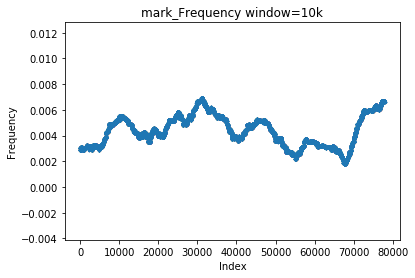

In [65]:
import matplotlib.pyplot as plt

frequency_list = [total_y_lst] 
 
x_values = list(range(1, len(total_y_lst)+1))

# Creating Scatter Plots
plt.scatter(x_values, frequency_list, marker='o', s=5)  
# 'o' denotes the scatterplot, s denotes the size of the points

# Add title and tags
plt.title('mark_Frequency window=10k')
plt.xlabel('Index')
plt.ylabel('Frequency')
# Save plots
plt.savefig('Prob_Xwindow/mark_10k_scatter_plot.png',dpi=300)

change_y_lst：改变的次数  
total_y_lst：y=1的总数

#### window_data : 1489258 rows × 184 columns -- Unnamed: 0

#### data：1489358 rows × 183 columns

In [66]:
cuted_data = after_window_data.iloc[:len(total_y_lst)].drop(columns=['Unnamed: 0','y_label'])

#### cuted_data:1489159 rows × 182 columns

### 开始训练！！！！

In [67]:
cuted_data['Depth']  = cuted_data['Depth'].astype(int)

In [68]:
X_data = cuted_data

In [69]:
y_data = pd.DataFrame(total_y_lst,columns=['y_label'])

In [70]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)

可怜的上采样

In [71]:
# y_train.reset_index(drop=True, inplace=True)
# X_train.reset_index(drop=True, inplace=True)

# combined_df = pd.concat([X_train, y_train], axis=1)


# from sklearn.utils import resample
# df_majority = combined_df[combined_df.y_label==0]
# df_minority = combined_df[combined_df.y_label==1]

# # 上采样少数类
# df_minority_upsampled = resample(df_minority, 
#                                  replace=True,                      # 采样后的样本可以有重复
#                                  n_samples=len(df_majority),       # 要匹配的数量
#                                  random_state=123)                 # 可复现的随机种子

# # 结合多数类和上采样的少数类
# df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# df_upsampled[['y_label']].value_counts()

# X_train_upsampled = df_upsampled.drop(columns=['y_label'])
# y_train_upsampled = df_upsampled['y_label']

In [72]:
# 创建LightGBM数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [73]:
import numpy as np

In [74]:
# 设置参数
params = {
    "objective": "regression",  # 回归任务
    "metric": "rmse",  # 评估指标为均方根误差
    "boosting_type": "gbdt",  # GBDT算法
    "num_leaves": 31,  # 叶子节点数量
    "learning_rate": 0.1,  # 学习率
    "early_stopping_rounds":10,
    'max_depth': 4,
    "verbose": -1  # 关闭详细日志
}

In [75]:
# 训练模型
num_round = 100  # 迭代轮数
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# 进行预测
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"均方根误差 (RMSE): {rmse}")

均方根误差 (RMSE): 0.0002516665322925307


In [76]:
# 保存模型到文件
import joblib
model_filename = 'marks_model/marks_lgb_10k_window_Regre.pkl'
joblib.dump(bst, model_filename)
print(f"Model saved to {model_filename}")

Model saved to marks_model/marks_lgb_10k_window_Regre.pkl
